In [84]:
import numpy as np
import keras
import os
import math
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle

In [2]:
!ls ../train/joints/

leapJoints  mpJoints  myjoints.png  readme.md


In [105]:
#leap numerical data directory
data_dir = "../train/joints/mpJoints"

In [106]:
fileNames = [file for file in 
os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, file))]
classes = list(sorted(set([x[0] for x in fileNames])))
Ys = [classes.index(x[0]) for x in fileNames]

In [107]:
def unpickle(filepath):
    with open(filepath, "rb") as input_file:
        e = pickle.load(input_file)
    return e

def train_val_test_split(dataX, dataY, train = 0.7, val = 0.2, test=0.1):
    x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test/(test + val)) 

    return x_train, x_val, x_test, y_train, y_val, y_test

In [108]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(fileNames, Ys)

In [109]:
class JointDataGenerator(keras.utils.all_utils.Sequence):
    def __init__(self, IDs, labels,data_directory, batch_size=4, dim=(22,22), n_classes=11, shuffle=True, calculate='angle'):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.IDs = IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = []
        self.data_dir = data_directory
        self.calculate = calculate
        
        
        if self.calculate=="angle":
            #The angle between vectors aply formula that uses arccos to get the angle (in radians)
            #https://www.youtube.com/watch?v=ECNH_1TTOjs
            self.minX = np.arccos(1)    #math.PI
            self.maxX = np.arccos(-1)   #0
        else: # calculate == "distance":
            #position data is normalized in range <0,1>, we can estimate the max and min distances with that info
            self.minX = self.distance_between([0,0,0], [0,0,0])
            self.maxX = self.distance_between([0,0,0], [1,1,1]) 
        

        self.update_indexes()
        
    def update_indexes(self):
        self.indexes = np.arange(len(self.IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self): 
        # will always omit last batch of data 
        # so the train dataset will always be lower than expected
        return int(np.floor(len(self.IDs) / self.batch_size))
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.IDs[k] for k in indexes]
        
        X,y = self.__data_generation(list_IDs_temp)
        
        return X,y
    
    def unit_vector(self, vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)
    
    def angle_between(self, v1, v2):
        """ Returns the angle in radians between vectors 'v1' and 'v2'. """
        v1_u = self.unit_vector(v1)
        v2_u = self.unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    def distance_between(self, v1, v2):
        return math.dist(v1, v2)
    
    def min_max_scale(self, x):
        return (x-self.minX)/(self.maxX - self.minX)
    
    def calcAngles(self, jointVectors): #todo change leapVectors -> jointVectors
        data = np.zeros((max(jointVectors.shape), max(jointVectors.shape), 1))
        for i_ind, row_i in enumerate(jointVectors):
            for j_ind, row_j in enumerate(jointVectors):
                data[i_ind][j_ind]=[self.min_max_scale(self.angle_between(row_i, row_j))]
        return data
    
    def calcDistances(self, jointVectors):
        data = np.zeros((max(jointVectors.shape), max(jointVectors.shape), 1))
        for i_ind, row_i in enumerate(jointVectors):
            for j_ind, row_j in enumerate(jointVectors):
                data[i_ind][j_ind]=[self.min_max_scale(self.distance_between(row_i, row_j))]
        return data    
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, 1))
        y = np.empty((self.batch_size), dtype=int)
        
        
        for i, ID in enumerate(list_IDs_temp):
            data = unpickle(f"{self.data_dir}/{ID}")
            if self.calculate == "angle":
                X[i] = self.calcAngles(data)
            else: #calculate distance
                X[i] = self.calcDistances(data)
            y[i] = self.labels[ID]
            
        return X, to_categorical(y, num_classes = self.n_classes)

In [110]:
train_generator = JointDataGenerator(x_train[:5], dict(zip(x_train, y_train)), data_dir, calculate='dist')    #calculate euclidian distance between each joint
# train_generator = JointDataGenerator(x_train[:5], dict(zip(x_train, y_train)), data_dir, calculate='angle') #calculate angle (in radians) between each joint 

In [45]:
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'. """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [8]:
def do_the_thing(data):
    print(data)

In [42]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'. """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [78]:
y[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

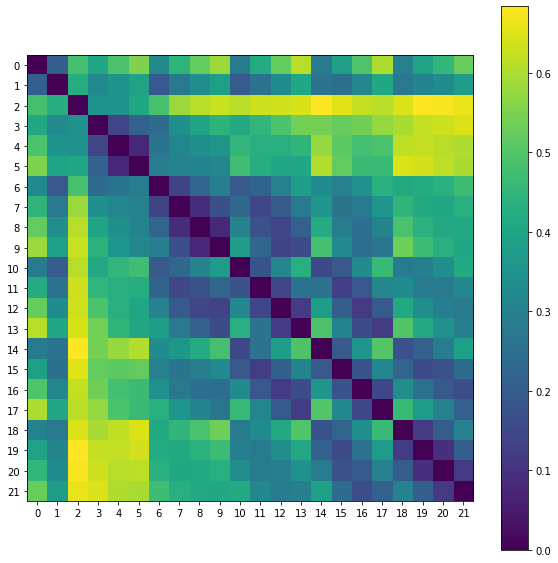

B


In [104]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots( figsize=(10,10))
shw = ax.imshow(X[0])

# make bar
bar = plt.colorbar(shw)
  
# show plot with labels
plt.xticks(np.arange(0,22,1))
plt.yticks(np.arange(0,22,1))
plt.show()
print(classes[np.argmax(y[0], axis=-1)])